# Plug flow reactor modeling

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]

We start by importing all required tools.

Since models will get larger and larger the code is [here](utilities/nb018.py).

In [2]:
import cantera as ct
import casadi as cs

from utilities.nb018 import NASA7_CH4_1S as nasa7
from utilities.nb018 import MethaneCombustion1S
from utilities.nb018 import ConsSectWalledPfr
from utilities.nb018 import validate_database_properties
from utilities.nb018 import check_equivalent_cantera
from utilities.nb018 import solve_constrain_method
from utilities.nb018 import solve_multiple_shooting
from utilities.nb018 import plot_reactor_state

To simplify mechanism import, we add this repository's database path to Cantera path.

In [3]:
ct.add_directory("../databases/kinetics/Methane_Low_Order/")

## Atmosphere setup

To compute inlet gas composition we use Cantera's `set_equivalence_ratio` with the given fuel and oxidizer.

In what follows we simulate stoichiometric combustion for ease of validation and testing.

Dictionary `Y0` will be used later to initialize the ODE/DAE system.

In [4]:
fuel = "CH4: 1.00"
oxid = "N2: 0.78, O2: 0.21, AR: 0.01, H2O: 0.006"

gas = ct.Solution("1S_CH4_MP1.yaml")
gas.TP = 1000.0, ct.one_atm
gas.set_equivalence_ratio(1.0, fuel, oxid)

Y0 = dict(zip(gas.species_names, gas.Y))
Y0

{'CH4': 0.05475852906475247,
 'O2': 0.2184333868994514,
 'CO2': 0.0,
 'H2O': 0.0035136816274174442,
 'N2': 0.7103078559179237,
 'AR': 0.012986546490454888}

## Thermodynamics validation

In the course of model development, this notebook targets a standalone CasADi implementation of PFR.

Thus, NASA7 polynomials are treated symbolically and reimplemented in the external module `nb018`.

The next cell validates the specific heat and enthalpy of concerned species against Cantera values.

In [5]:
validate_database_properties(nasa7, gas)

True

## Model inputs

<!-- 
$$
\dot{m}=\rho{}u{}A_{c}\qquad\implies\qquad{}\rho{}u{}=\frac{\dot{m}}{A_{c}}
$$ -->

In [6]:
# Create mixture to simulate system.
mix = MethaneCombustion1S()

# Number of slices over flow direction.
Nz = 150

# Reactor length [m].
Lz =  10.0

# Reactor radius [m].
Rz = 0.6

# Heat transfer coefficient [W/(m².K)].
htc = 7.0

# Environment temperature [K].
Tw = 300.0

# Total inlet flow rate [kg/s].
mdot = 0.12

# Inlet temperature [K].
t0 = 600.0

# Inlet composition [mass fractions].
y0 = [*list(Y0.values())]

# Reactor cross-section area [m²].
Ac = cs.pi * Rz**2

# Reactor internal perimeter [m].
Pc = 2 * cs.pi * Rz

## Reference values

To given an idea of expected results, a single stirred reactor is simulated with Cantera.

In [7]:
check_equivalent_cantera(gas, mdot)


  CH4_MP1:

       temperature   2866.3 K
          pressure   1.0133e+05 Pa
           density   0.11772 kg/m^3
  mean mol. weight   27.689 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        5.3933e+05        1.4934e+07  J
   internal energy       -3.2136e+05       -8.8982e+06  J
           entropy             10166        2.8148e+05  J/K
    Gibbs function       -2.8599e+07       -7.9189e+08  J
 heat capacity c_p            1550.6             42935  J/K
 heat capacity c_v            1250.3             34620  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
               CH4        1.2529e-05        2.1625e-05           -46.401
                O2         4.998e-05         4.325e-05           -40.156
               CO2           0.15018          0.094488           -5

## Adiabatic reactor

Setting global heat transfer coefficient to zero should lead to similar results.

Below we make a call to the basic constrained solver to check this then print numerical values in next cell.

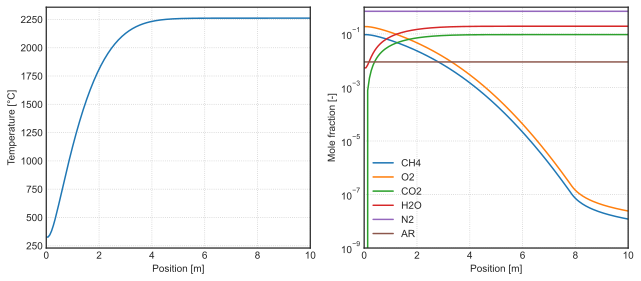

In [8]:
df1, out1 = solve_constrain_method(
    mix, Nz, Lz, y0, t0, mdot,
    Ac, Pc, 0.0, Tw)
plot_reactor_state(df1)

We can compare the solution to multiple shooting approach.

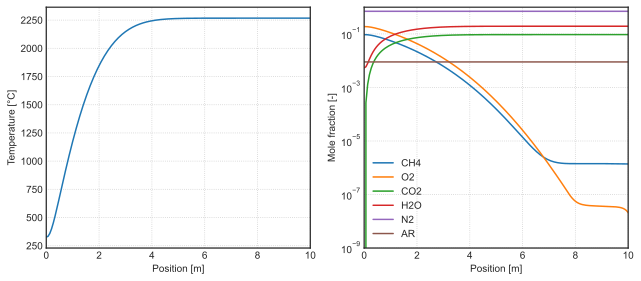

In [9]:
df2, out2 = solve_multiple_shooting(
    mix, Nz, Lz, y0, t0, mdot, 
    areac=lambda _: Ac,
    perim=lambda _: Pc,
    htcfn=lambda _: 0.0,
    tempw=lambda _: Tw,
    kefun=lambda z: z / Lz)
plot_reactor_state(df2)

Below we inspect the tail of tables for end temperature check.

In [10]:
df1.tail()

,T,X_CH4,X_O2,X_CO2,X_H2O,X_N2,X_AR,bal,z
146,2534.692757,1.363945e-08,2.727886e-08,0.094509,0.194419,0.70207,0.009001,1.0,9.733333
147,2534.692766,1.321377e-08,2.642749e-08,0.094509,0.194419,0.70207,0.009001,1.0,9.800000
148,2534.692773,1.281348e-08,2.562692e-08,0.094509,0.194419,0.70207,0.009001,1.0,9.866667
149,2534.692781,1.243641e-08,2.487277e-08,0.094509,0.194419,0.70207,0.009001,1.0,9.933333
150,2534.692787,1.208060e-08,2.416115e-08,0.094509,0.194419,0.70207,0.009001,1.0,10.000000


In [11]:
df2.tail()

,T,X_CH4,X_O2,X_CO2,X_H2O,X_N2,X_AR,bal,z
146,2540.483142,0.000001,3.205830e-08,0.094509,0.194419,0.702069,0.009001,1.0,9.733333
147,2540.483221,0.000001,3.048797e-08,0.094509,0.194419,0.702069,0.009001,1.0,9.800000
148,2540.483297,0.000001,2.827577e-08,0.094509,0.194419,0.702069,0.009001,1.0,9.866667
149,2540.483368,0.000001,2.522500e-08,0.094509,0.194419,0.702069,0.009001,1.0,9.933333
150,2540.483432,0.000001,2.111373e-08,0.094509,0.194419,0.702069,0.009001,1.0,10.000000


It is also important to check Ipopt output and confirm solution has converged.

In [12]:
print(out1)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:     1050
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1050
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1050
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 39

     

In [13]:
print(out2)

Total number of variables............................:     1050
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1050
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1050
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   1.0000000000000000e+00    1.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   9.9306425962308820e-09    9.9306425962308820e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

## Reactor with heat transfer

Next, we simulate again the same reactor but with heat losses, leading to more realistic results.

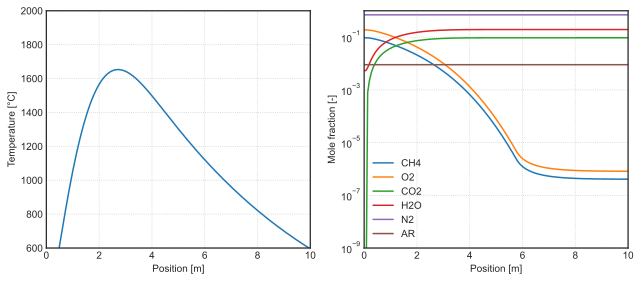

In [14]:
df, out1 = solve_constrain_method(
    mix, Nz, Lz, y0, t0, mdot,
    Ac, Pc, htc, Tw)
plot_reactor_state(df, ylim1=(600, 2000))

Again, we compare the solution to multiple shooting approach.

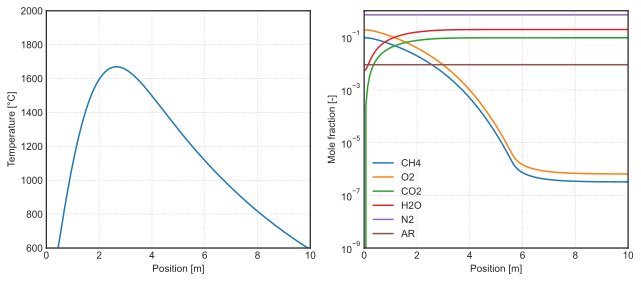

In [15]:
df, out2 = solve_multiple_shooting(
    mix, Nz, Lz, y0, t0, mdot, 
    areac=lambda _: Ac,
    perim=lambda _: Pc,
    htcfn=lambda _: htc,
    tempw=lambda _: Tw,
    kefun=lambda z: z / Lz)
plot_reactor_state(df, ylim1=(600, 2000))

In [16]:
print(out1)

Total number of variables............................:     1050
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1050
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1050
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............:   1.0000000000000000e+00    1.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   1.5596117139964123e-10    2.1225616819720017e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

In [17]:
print(out2)

Total number of variables............................:     1050
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1050
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1050
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 55

                                   (scaled)                 (unscaled)
Objective...............:   1.0000000000000000e+00    1.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   5.4569682106375694e-12    5.4569682106375694e-12
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

## Shell temperature prediction

In [18]:
dR = 6 * 0.0254
Nz = 170

solver = ConsSectWalledPfr(Rz, Lz, Nz, dR, mdot)
df, out = solver.solve(y0, t0)

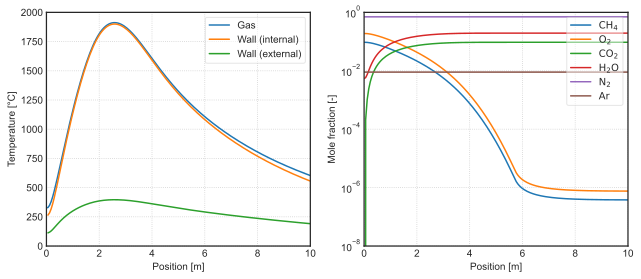

In [19]:
solver.plot_reactor_state(df, ylim1=(0, 2000), ylim2=(1e-8, 1))

In [20]:
df

,Tg,T1,T2,X_CH4,X_O2,X_CO2,X_H2O,X_N2,X_AR,bal,z
0,600.000000,NaN,NaN,9.450945e-02,1.890189e-01,0.000000,0.005401,0.70207,0.009001,1.0,0.000000
1,603.113891,538.134442,386.107064,9.429924e-02,1.885985e-01,0.000210,0.005821,0.70207,0.009001,1.0,0.058824
2,621.282780,557.035068,391.966150,9.347844e-02,1.869569e-01,0.001031,0.007463,0.70207,0.009001,1.0,0.117647
3,652.498071,589.850791,401.850580,9.211423e-02,1.842285e-01,0.002395,0.010191,0.70207,0.009001,1.0,0.176471
4,694.000847,633.921089,414.581447,9.030260e-02,1.806052e-01,0.004207,0.013814,0.70207,0.009001,1.0,0.235294
...,...,...,...,...,...,...,...,...,...,...,...
166,896.581403,850.268772,469.463228,3.804926e-07,7.609853e-07,0.094509,0.194419,0.70207,0.009001,1.0,9.764706
167,891.501519,844.868408,468.225580,3.802884e-07,7.605769e-07,0.094509,0.194419,0.70207,0.009001,1.0,9.823529
168,886.475203,839.522858,466.994597,3.800985e-07,7.601970e-07,0.094509,0.194419,0.70207,0.009001,1.0,9.882353
169,881.501797,834.231516,465.770266,3.799218e-07,7.598436e-07,0.094509,0.194419,0.70207,0.009001,1.0,9.941176


In [21]:
# print(out)

## Radiation properties

In [46]:
from utilities.nb018 import RealGasRadNNET

In [47]:
r = RealGasRadNNET()
r.absorptivity(0.5, 1000.0, 0.18, 0.09, 0.0001)

0.9999154618537244